# Chap 18 - Ex3: Apply ARIMA for electric_production.csv data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

np.set_printoptions(suppress = True)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

In [2]:
electric = (
    pd.read_csv('data/electric_production.csv')
    .assign(DATE=lambda df: pd.to_datetime(df['DATE'], yearfirst=True, dayfirst=False))
    .set_index('DATE')
    .asfreq('D')  # Change 'D' to 'M', 'W', etc. if needed
    .assign(IPG2211A2N=lambda df: df['IPG2211A2N'].fillna(df['IPG2211A2N'].median()))
)

electric

,IPG2211A2N
DATE,
1939-01-01,3.3842
1939-01-02,54.1884
1939-01-03,54.1884
1939-01-04,54.1884
1939-01-05,54.1884
...,...
2018-07-28,54.1884
2018-07-29,54.1884
2018-07-30,54.1884


In [3]:
electric_2010 = electric[electric.index.year >= 2010]
electric_2010

,IPG2211A2N
DATE,
2010-01-01,119.2479
2010-01-02,54.1884
2010-01-03,54.1884
2010-01-04,54.1884
2010-01-05,54.1884
...,...
2018-07-28,54.1884
2018-07-29,54.1884
2018-07-30,54.1884


## <span style  = 'color:yellow'> Check the seasonal feature of the time series data

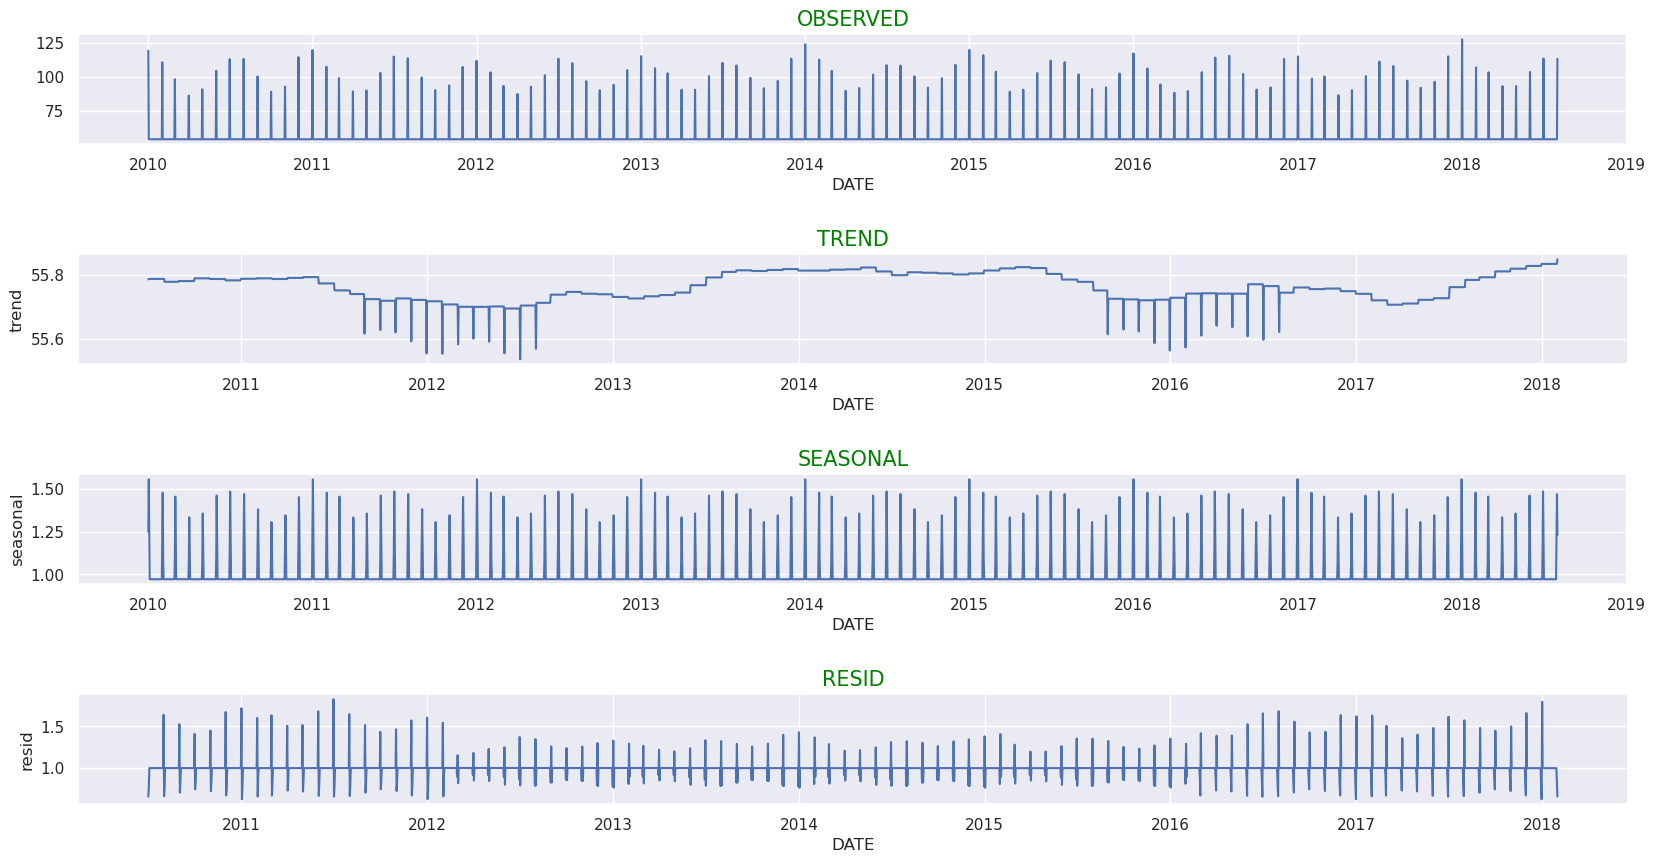

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_check = seasonal_decompose(
    electric_2010, 
    model='multiplicative',
    period=365
)

attr = ['observed', 'trend', 'seasonal', 'resid']

sbn.set_theme(style='darkgrid')
plt.figure(figsize = (20,10))
plt.subplots_adjust(hspace=1)
for i in range(len(attr)):
    plt.subplot(4,1,i+1)
    sbn.lineplot(data=getattr(seasonal_check, attr[i]))
    plt.title(attr[i].upper(), size = 15, color = 'green')
plt.show()

## <span style  = 'color:yellow'> Build SARIMA model (because the data has seasonality)

In [6]:
import pmdarima as pm

train_set, test_set = pm.model_selection.train_test_split(electric_2010, train_size=int(0.8*electric_2010.shape[0]))

arima_model = pm.auto_arima(train_set,                 
                start_p = 2, max_p = 5,
                start_q = 2, max_q = 5,
                m=7, seasonal = True,
                suppress_warnings=True, 
                stepwise=True, trace = True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=18369.577, Time=3.01 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=18005.881, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=18004.138, Time=1.36 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=18003.633, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=27351.469, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=18005.007, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=18005.606, Time=1.40 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=18002.215, Time=0.89 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=18004.213, Time=1.70 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=18004.157, Time=0.66 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=18005.013, Time=1.79 sec
 ARIMA(0,0,2)(0,0,2)[7] intercept   : AIC=17999.373, Time=2.38 sec
 ARIMA(0,0,2)(0,0,1)[7] intercept   : AIC=18001.552, Time=0.47 sec
 ARIMA(0,0,2)(1,0,2)[7] intercept   : AIC=18001.370, Time=2.42 sec
 ARIMA(0,0,2)(1,0,1

## <span style  = 'color:yellow'> Forecast

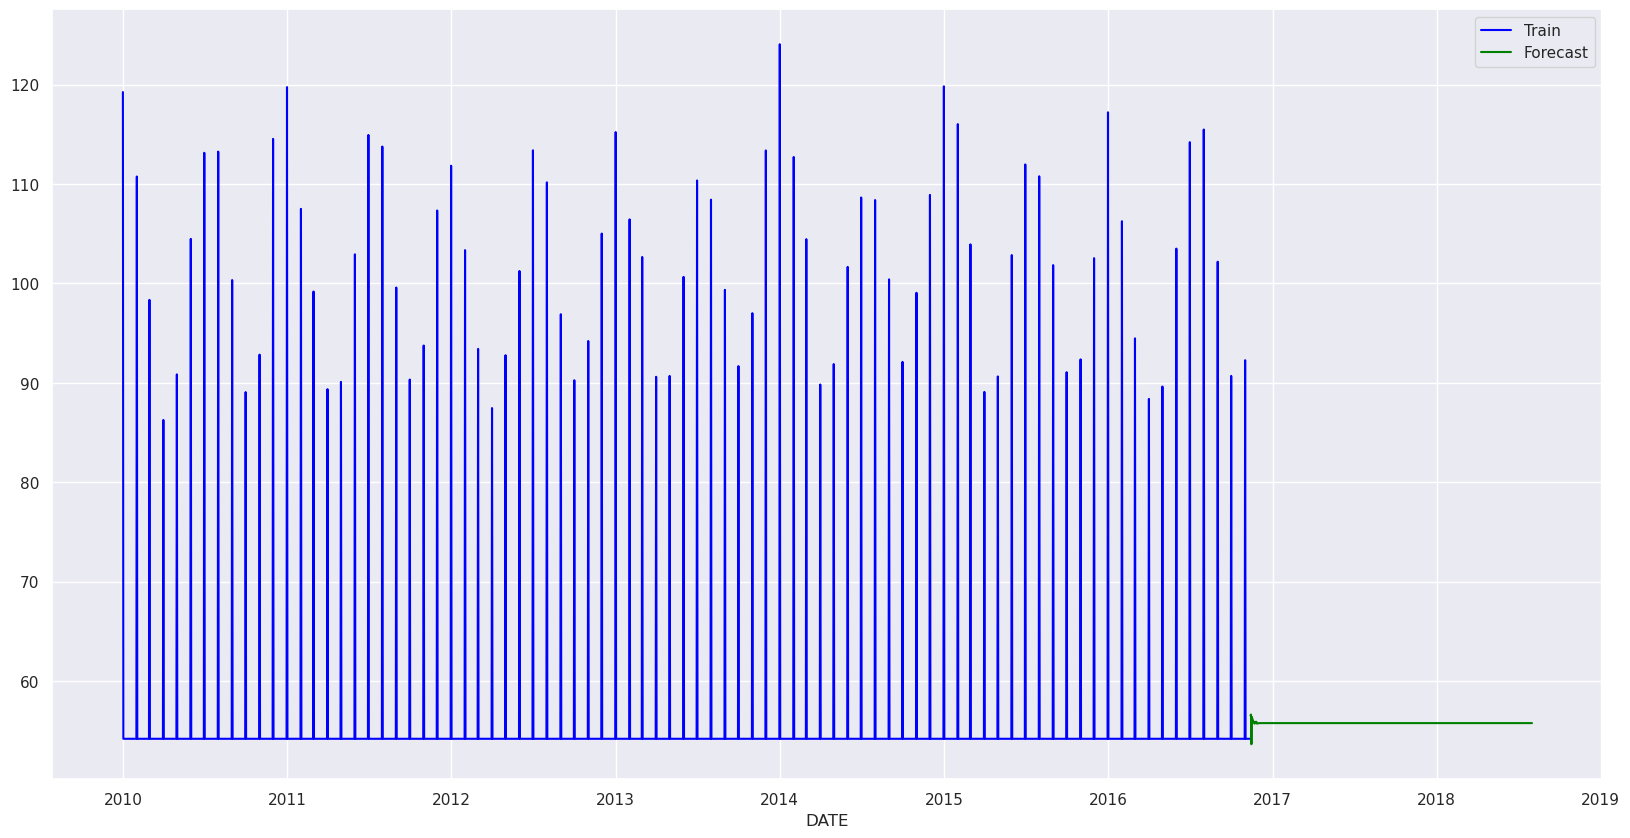

In [7]:
forecasts_test = arima_model.predict(test_set.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
plt.figure(figsize=(20, 10))
sbn.lineplot(x=train_set.index, y=train_set.values.ravel(), color='blue', label='Train')
sbn.lineplot(x=forecasts_test.index, y=forecasts_test.values.ravel(), color='green', label='Forecast')
plt.legend()
plt.show()

## <span style  = 'color:yellow'> Evaluation

Accuracy on train set: 0.0004660090065646827
Accuracy on test set: -0.00034109374320134833

Mean squared error test set: 83.20812658305228
Mean absolute error test set: 3.1378502328829345



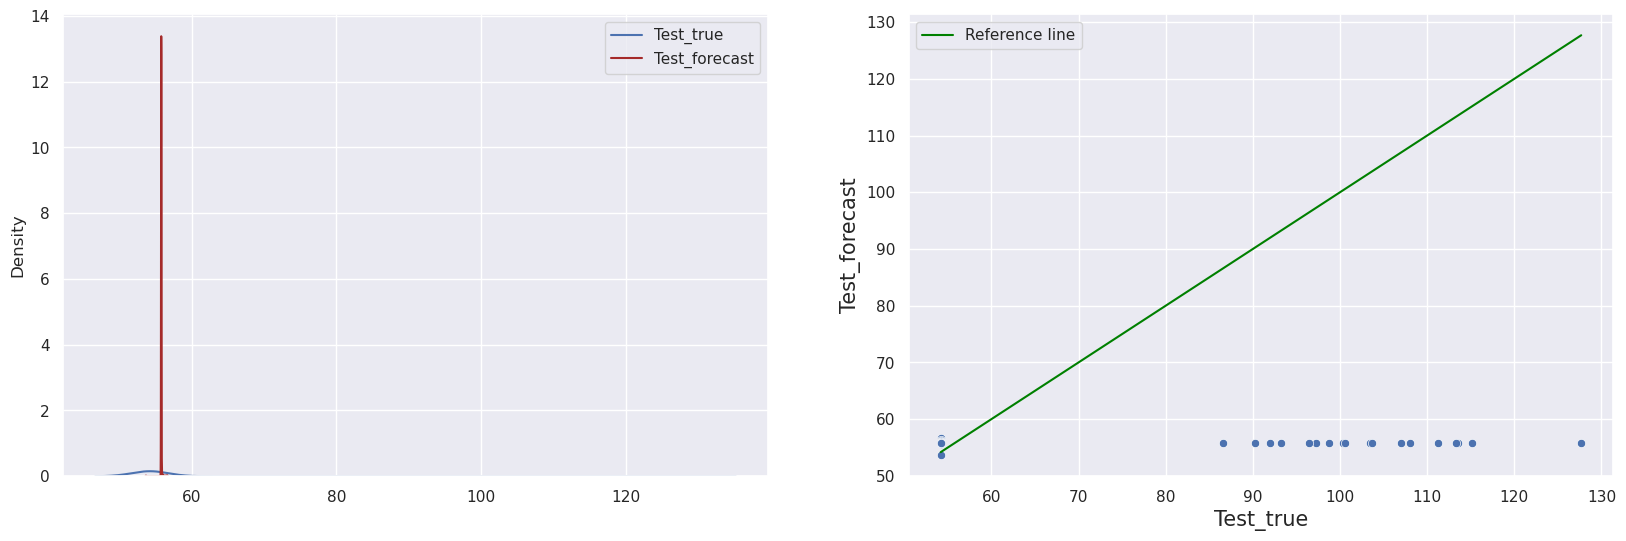

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

forecasts_train = arima_model.predict(train_set.shape[0])

print(f'Accuracy on train set: {r2_score(train_set.values, forecasts_train.values)}')
print(f'Accuracy on test set: {r2_score(test_set.values, forecasts_test.values)}')
print()

print(f'Mean squared error test set: {mean_squared_error(test_set.values, forecasts_test.values)}')
print(f'Mean absolute error test set: {mean_absolute_error(test_set.values, forecasts_test.values)}')
print()

sbn.set_theme(style='darkgrid')
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sbn.kdeplot(test_set.values,  label = "Test_true", color = 'green')
sbn.kdeplot(forecasts_test.values, label = "Test_forecast", color = 'brown')
plt.legend()

plt.subplot(1,2,2)
sbn.lineplot(x = [test_set.values.min(), test_set.values.max()], 
             y = [test_set.values.min(), test_set.values.max()], 
             label = 'Reference line', color = 'green')
sbn.scatterplot(x = test_set.values.ravel(), y = forecasts_test.values.ravel())
plt.xlabel("Test_true", size=15)
plt.ylabel("Test_forecast", size=15)
plt.show()